## Part I: Data Pre-processing

In [6]:
import pandas as pd
import numpy as np

In [50]:
# Download the Google Analogy dataset
# !wget http://download.tensorflow.org/data/questions-words.txt

In [51]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [52]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [53]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.
questions = []
categories = []
sub_categories = []
now_categories = "semeantic"
now_sub_categories = ""
count = 0
for line in data:
    if(":" in line):
        count += 1
        now_sub_categories = line
        if(count >= 6):
            now_categories = 'syntatic'
        continue
    else:
        questions.append(line)
        categories.append(now_categories)
        sub_categories.append(now_sub_categories)


In [54]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [55]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semeantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,semeantic,: capital-common-countries
2,Athens Greece Beijing China,semeantic,: capital-common-countries
3,Athens Greece Berlin Germany,semeantic,: capital-common-countries
4,Athens Greece Bern Switzerland,semeantic,: capital-common-countries


In [56]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [7]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [57]:
data = pd.read_csv("questions-words.csv")

In [11]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 128.1/128.1MB downloaded
The Gensim model loaded successfully!


In [26]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      A, B, C, D = analogy.split(' ')
      output = model.most_similar(positive=[B.lower(), C.lower()], negative=[A.lower()], topn=1)
      if(D[0].isupper()): pred = output[0][0].capitalize()
      else: pred = output[0][0]
      preds.append(pred)
      golds.append(D)

100%|██████████| 19544/19544 [04:13<00:00, 77.22it/s]


In [27]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semeantic, Accuracy: 65.3399481339497%
Category: syntatic, Accuracy: 61.255269320843084%
Sub-Category: capital-common-countries, Accuracy: 93.87351778656127%
Sub-Category: capital-world, Accuracy: 88.94783377541998%
Sub-Category: currency, Accuracy: 14.203233256351039%
Sub-Category: city-in-state, Accuracy: 30.806647750304013%
Sub-Category: family, Accuracy: 81.62055335968378%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category: gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category: gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category: gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category: gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category: gram6-nationality-adjective, Accuracy: 87.86741713570981%
Sub-Category: gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category: gram8-plural, Accuracy: 71.996996996997%
Sub-Category: gram9-plural-verbs, Accuracy: 58.39080459770115%


In [64]:
filtered_data = data[data['SubCategory'].str.contains('family', case=False)]
unique_word = []

for analogy in tqdm(filtered_data['Question']):
    words = analogy.split(' ')
    for word in words:
        if(word not in unique_word):
            unique_word.append(word)
            
vectors = []
for word in unique_word:
    vectors.append(model[word])

vectors = np.array(vectors)
print(vectors.shape)

100%|██████████| 506/506 [00:00<00:00, 506882.69it/s]

(46, 100)


100%|██████████| 506/506 [00:00<00:00, 505916.05it/s]

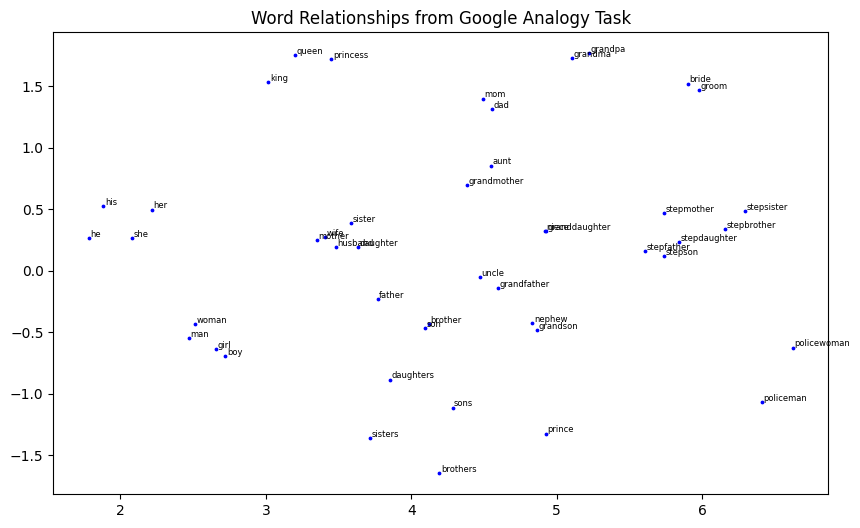

In [71]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
tsne = TSNE(n_components=2)

filtered_data = data[data['SubCategory'].str.contains('family', case=False)]
unique_word = []

for analogy in tqdm(filtered_data['Question']):
    words = analogy.split(' ')
    for word in words:
        if(word not in unique_word):
            unique_word.append(word)

vectors = []
for word in unique_word:
    vectors.append(model[word])
    
vectors = np.array(vectors)
reduce_vectors= tsne.fit_transform(vectors)

# The following code refers to GPT
plt.figure(figsize=(10, 6))
plt.title("Word Relationships from Google Analogy Task")

for word, vector in zip(unique_word, reduce_vectors):
    x, y = vector
    plt.scatter(x, y, c='b', s=3)
    plt.annotate(word, (x+0.01, y+0.01), fontsize=6)

plt.savefig("word_relationships_pretrained.png", bbox_inches="tight")
plt.show()

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
# !gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
# !gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
# !gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
# !gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
# !gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
# !gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
# !gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
# !gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
# !gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
# !gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
# !gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [ ]:
# Extract the downloaded wiki_texts_parts files.
# !gunzip -k wiki_texts_part_*.gz

In [ ]:
# Combine the extracted wiki_texts_parts files.
# !cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [ ]:
# Check the first ten lines of the combined file
# !head -n 10 wiki_texts_combined.txt

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [13]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
output_path = 'wiki_texts_sample.txt'
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
        for line in f:
            if random.random() <= 0.2:
                output_file.write(line)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [6]:
# load saved sampled_txt

wiki_sampled_txt_path = 'wiki_texts_sample.txt'

with open(wiki_sampled_txt_path, 'r', encoding='utf-8') as file:
    sampled_data = file.readlines()
    
print("Total sampled lines:", len(sampled_data))

Total sampled lines: 1124826


In [7]:
# extend sample to 30%
import random

wiki_txt_path = "wiki_texts_combined.txt"
output_path = 'wiki_texts_temp.txt'

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
        for line in f:
            if random.random() <= 0.1:
                output_file.write(line)

In [2]:
additional_sample_path = 'wiki_texts_temp.txt'
output_path = 'wiki_texts_extend_sample.txt'

with open(additional_sample_path, "r", encoding="utf-8") as f:
    with open(output_path, "a", encoding="utf-8") as output_file:
        for line in f:
            output_file.write(line)

In [3]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.

# preprocess data and save to disk

from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.parsing.preprocessing import stem_text, strip_numeric

wiki_sampled_txt_path = 'wiki_texts_extend_sample.txt'
wiki_preprocess_path = 'wiki_texts_extend_processed.txt'

filters = [remove_stopwords]

with open(wiki_sampled_txt_path, 'r', encoding='utf-8') as file:
    with open(wiki_preprocess_path, "w", encoding="utf-8") as output_file:
        for line in tqdm(file):
            processed_line = preprocess_string(line, filters)
            output_file.write(' '.join(processed_line) + '\n')

1687167it [04:09, 6759.91it/s]


In [4]:
# wiki_preprocess_path = 'wiki_texts_processed.txt'
# wiki_sampled_txt_path = 'wiki_texts_sample.txt'
wiki_extend_txt_path = 'wiki_texts_extend_sample.txt'

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""
    def __iter__(self):
        for line in tqdm(open(wiki_extend_txt_path)):
            yield line.strip().split(' ')

corpus = MyCorpus()

In [5]:
from gensim.models import Word2Vec

# initialize model
model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4, epochs=5)

model.save("word2vec.model")

1687167it [04:45, 5906.12it/s]
1687167it [12:08, 2314.94it/s]
1687167it [12:08, 2315.97it/s]
1687167it [12:01, 2337.93it/s]
1687167it [12:00, 2342.36it/s]
1687167it [12:02, 2336.10it/s]


In [2]:
# load model
from gensim.models import Word2Vec

# model = Word2Vec.load("word2vec.model")
model = Word2Vec.load('checkpoint/trained_question/word2vec.model')

In [10]:
# train model
model.train(corpus, total_examples=model.corpus_count, epochs=5)

model.save("word2vec.model")

0it [00:00, ?it/s]

1124826it [05:16, 3550.60it/s]
1124826it [05:13, 3591.03it/s]
1124826it [05:13, 3587.14it/s]
1124826it [05:15, 3561.73it/s]
1124826it [05:17, 3538.90it/s]


In [6]:
data = pd.read_csv("questions-words.csv")

In [7]:
# collect questions-words data
abc_words = []

for analogy in tqdm(data['Question']):
    for word in analogy.split(' ')[:-1]:
        abc_words.append([word]) # only add A, B, C into list, prevent from leaking answer

100%|██████████| 19544/19544 [00:00<00:00, 123696.21it/s]


In [8]:
# build up new vocab and train
model.build_vocab(abc_words, update=True)

model.train(abc_words, total_examples=len(abc_words), epochs=5)

model.save("word2vec.model")

In [9]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      A, B, C, D = analogy.split(' ')
      output = model.wv.most_similar(positive=[B.lower(), C.lower()], negative=[A.lower()], topn=1)
      if(D[0].isupper()): pred = output[0][0].capitalize()
      else: pred = output[0][0]
      preds.append(pred)
      golds.append(D)

100%|██████████| 19544/19544 [59:23<00:00,  5.48it/s] 


In [10]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semeantic, Accuracy: 66.39981959634682%
Category: syntatic, Accuracy: 54.285714285714285%
Sub-Category: capital-common-countries, Accuracy: 82.21343873517787%
Sub-Category: capital-world, Accuracy: 79.28824049513705%
Sub-Category: currency, Accuracy: 14.203233256351039%
Sub-Category: city-in-state, Accuracy: 53.58735306039725%
Sub-Category: family, Accuracy: 87.15415019762845%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 23.18548387096774%
Sub-Category: gram2-opposite, Accuracy: 19.82758620689655%
Sub-Category: gram3-comparative, Accuracy: 73.49849849849849%
Sub-Category: gram4-superlative, Accuracy: 42.33511586452763%
Sub-Category: gram5-present-participle, Accuracy: 47.253787878787875%
Sub-Category: gram6-nationality-adjective, Accuracy: 85.30331457160726%
Sub-Category: gram7-past-tense, Accuracy: 49.80769230769231%
Sub-Category: gram8-plural, Accuracy: 63.36336336336337%
Sub-Category: gram9-plural-verbs, Accuracy: 53.5632183908046%


In [11]:
filtered_data = data[data['SubCategory'].str.contains('family', case=False)]
unique_word = []

for analogy in tqdm(filtered_data['Question']):
    words = analogy.split(' ')
    for word in words:
        if(word not in unique_word):
            unique_word.append(word)
            
vectors = []
for word in unique_word:
    vectors.append(model.wv[word])

vectors = np.array(vectors)
print(vectors.shape)

100%|██████████| 506/506 [00:00<00:00, 299847.11it/s]

(46, 100)


100%|██████████| 506/506 [00:00<00:00, 337411.42it/s]


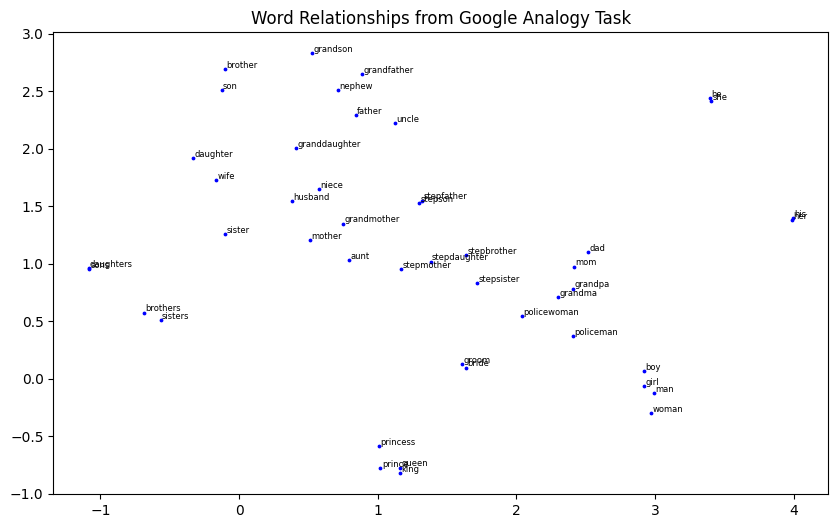

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`
tsne = TSNE(n_components=2)

filtered_data = data[data['SubCategory'].str.contains('family', case=False)]
unique_word = []

for analogy in tqdm(filtered_data['Question']):
    words = analogy.split(' ')
    for word in words:
        if(word not in unique_word):
            unique_word.append(word)

vectors = []
for word in unique_word:
    vectors.append(model.wv[word])
    
vectors = np.array(vectors)
reduce_vectors= tsne.fit_transform(vectors)

# The following code refers to GPT
plt.figure(figsize=(10, 6))
plt.title("Word Relationships from Google Analogy Task")

for word, vector in zip(unique_word, reduce_vectors):
    x, y = vector
    plt.scatter(x, y, c='b', s=3)
    plt.annotate(word, (x+0.01, y+0.01), fontsize=6)

plt.savefig("word_relationships_selftrained.png", bbox_inches="tight")
plt.show()

In [18]:
temp_model = Word2Vec.load('checkpoint/origin/word2vec.model')

In [19]:
distance = temp_model.wv['brother'] - model.wv['brother']
print(distance)

[ 4.0784354e+00 -7.1114135e+00  6.6136289e-01  2.8553247e+00
 -2.5747585e+00 -2.6305008e+00 -1.7492017e+00 -5.4826126e+00
  5.8150640e+00  6.8301573e+00  7.4546421e-01 -3.2576599e+00
 -5.3610640e+00 -4.2717547e+00  1.0694120e+00  2.3353083e+00
  1.8049740e+00  3.1798344e+00  1.6640697e+00 -1.6734527e+00
 -3.3374791e+00  2.7111821e+00 -5.3308468e+00 -3.1068525e+00
 -2.3926282e+00  4.7047347e-01 -4.6044436e+00  2.5537210e+00
 -7.8520334e-01  2.9438953e+00  3.3269229e+00 -4.4900203e+00
 -1.2896779e+00 -4.7816806e+00  2.4436674e+00  1.0638313e+01
  2.8781304e+00  5.1077666e+00 -3.2129354e+00 -8.8215866e+00
 -5.4371786e-01  5.2065563e-01 -7.5863302e-03 -2.0236804e+00
  1.4926555e+00  6.3195987e+00 -1.7342604e+00 -5.8158498e+00
 -6.4694369e-01 -4.1895833e+00  3.8218870e+00  1.9506197e+00
  1.8083389e+00  2.0992470e+00  9.5253581e-01 -1.7120984e+00
  2.3873940e+00  7.4796963e-01  3.1670809e+00  4.5107585e-01
  7.1431894e+00 -2.5962477e+00 -1.6917393e+00  6.7577453e+00
  6.8420138e+00  9.26567